# CIE Project A - Group 7
## ---> Data processing

### Imports

In [64]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sp
from sklearn import preprocessing ##importing for normalization

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.frameon'] = True
%matplotlib widget

# import tensorflow as tf
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix

#### Get the root directory and change to it

In [65]:
rootdir = os.getcwd()
os.chdir(rootdir)

### Variable Assignment

In [66]:
gyrFile = 'Gyroscope'
accFile = 'Accelerometer'

normal = 'Normal'
upstairs = 'Upstairs'
downstairs = 'Downstairs'

smartphone = [3]

s1 = 'Smartphone1'
s3 = 'Smartphone3'

s = [s3]

gaitpos = [normal, upstairs, downstairs]

### Data Parsing

#### Define variables for raw data

In [67]:
count = 0

# Naming convention - gyr(oscope)_s(martphone_location)) and Same for acceleraoemeter
# All the data is stored in a list of dataframes. So, gyr{gaitpos}_s{martphone_location}[0, 1, 2, .....] gives the data as sorted by name in the file directory.
# gyrNormal_s1[0] gives the gyroscope data of the subject180_Normal sample 01 in the normal gait position.
# gyrNormal_s1[1] gives the gyroscope data of the subject180_Normal sample 02 in the normal gait position.
# 
# gyrNormal_s[2] gives the gyroscope data of the subject181_Normal sample 01 in the normal gait position.
# 
# and so on. 

# Create arrays for Raw data
for x in gaitpos:
    for y in smartphone:
        # variables of raw the data
        globals()['gyr%s_s%s' % (x, y)] = []
        globals()['acc%s_s%s' % (x, y)] = []
##---------------------------------------------------------------------------------------------------------------------

#### Parsing gyroscope and accelerometer data at all gait positions (Smartphone 1 - Rear Right) & (Smartphone 3 - Front Right)

In [68]:
for subdir, dirs, files in os.walk(rootdir):
    for foldername in s:
        for gait in gaitpos:    
        
            gyr = eval(f'gyr{gait}_s{foldername[10]}')
            acc = eval(f'acc{gait}_s{foldername[10]}')
            
            if foldername.lower() in subdir.lower():
                if gait.lower() in subdir.lower():
    
                    for file in files:

                        if gyrFile.lower() in file.lower():
                            count = count + 1
                            # print(f'#{count} -- {os.path.join(subdir, file)}')

                            with open(os.path.join(subdir, file), 'r') as f: # open in read-only mode
                                gyrData = pd.read_csv(f)
                                # Assemble the data into a tensor
                                gyr.append(gyrData)

                        if accFile in file:
                            count = count + 1
                            # print(f'#{count} -- {os.path.join(subdir, file)}')

                            with open(os.path.join(subdir, file), 'r') as f: # open in read-only mode
                                accData = pd.read_csv(f)
                                # Assemble the data into a tensor
                                acc.append(accData)

#### Check if the data is collected correctly after parsing

In [69]:
# # getting the data shape for reference
# for j in gaitpos:
#     for i in smartphone:
#             gyrl = eval(f'gyr{j}_s{i}')
#             accl = eval(f'acc{j}_s{i}')

#             print(f'Shape of gyr{j}_s{i} is ------ {np.asarray((gyrl), dtype = list).shape}')
#             print(f'Shape of acc{j}_s{i} is ------ {np.asarray((accl), dtype = list).shape} \n')

### Data Validation and Preprocessing

#### -- No need to run -- Frequency check of all the data before filtering

In [70]:
freqGyr = []
freqAcc = []

# Loop through the variables and check if all the data is collected
for j in gaitpos:
    for i in smartphone:
        # Calculating gyroscope frequency before preprocessing
        gyrl = eval(f'gyr{j}_s{i}')
        ng = len(gyrl)

        # loop to calculate the frequency over all the data
        for s in range(0, ng):
            time = np.asarray(gyrl[s].iloc[:,0])

            freqG = np.round(len(time)/(time[-1]))
            freqGyr.append(freqG)
        
        # Calculating accelerometer frequency before preprocessing
        accl = eval(f'acc{j}_s{i}')
        na = len(accl)

        # loop to calculate the frequency over all the data
        for s in range(0, na):
            time = np.asarray(accl[s].iloc[:,0])

            freqA = np.round(len(time)/(time[-1]))
            freqAcc.append(freqA)

for i in range(0, len(freqGyr)):
    if freqGyr[i] < 10:
        print(f'Position of the frequency issue is at freqGyr:{i} and the frequency is {freqGyr[i]}')
for j in range(0, len(freqAcc)):
    if freqAcc[j] < 10:
        print(f'Position of the frequency issue is at freqAcc:{j} and the frequency is {freqAcc[j]}')

### Filter Data

#### Lowpass filter (Butterworth) function

In [71]:
#Filter the data to remove noise

# inputs for the function is the data, the sampling frequency, the cutoff frequency.
def dataFilter(dataInput, fs=200, fc=5, order = 2):
    Filtrd = np.zeros(dataInput.shape)
    w = fc / (fs * 0.5)
    b, a = sp.butter(fc, w, 'low')
    
    #Filter the X, Y and Z axis of the input data
    for i in range(0, 3):
        Filtrd[:,i] = sp.filtfilt(b, a, dataInput.iloc[:,i+1])

    return Filtrd

##### -- Different filter check -- Chebyshev filter

In [72]:
'''
# chebyshev filter for the accelerometer data
def chebyFilter(dataInput, fs=200, fc=5, order = 2):
    Filtrd = np.zeros(dataInput.shape)
    w = fc / (fs * 0.5)
    b, a = sp.cheby2(order, 20, w, 'low')
    
    #Filter the X, Y and Z axis of the input data
    for i in range(0, 3):
        Filtrd[:,i] = sp.filtfilt(b,a, dataInput.iloc[:,i+1])
    
    return Filtrd
'''

"\n# chebyshev filter for the accelerometer data\ndef chebyFilter(dataInput, fs=200, fc=5, order = 2):\n    Filtrd = np.zeros(dataInput.shape)\n    w = fc / (fs * 0.5)\n    b, a = sp.cheby2(order, 20, w, 'low')\n    \n    #Filter the X, Y and Z axis of the input data\n    for i in range(0, 3):\n        Filtrd[:,i] = sp.filtfilt(b,a, dataInput.iloc[:,i+1])\n    \n    return Filtrd\n"

##### -- Test -- the dataFilter function and its dependency on the frequency input

In [73]:
'''gyrF = []
accF = []
ng = len(gyrNormal_s1)
na = len(accNormal_s1)

for i in range(0, ng):
    timeg = np.asarray(gyrNormal_s1[i].iloc[:,0])
    freqG = np.round(len(timeg)/(timeg[-1]))
    gyrF.append(freqG)

for j in range(0, na):
    timea = np.asarray(accNormal_s1[j].iloc[:,0])
    freqA = np.round(len(timea)/(timea[-1]))
    accF.append(freqA)

gyrFilt = []
accFilt = []

for rg in range(0, ng):
    gf = dataFilter(gyrNormal_s1[rg], fs = 100)
    gyrFilt.append(gf)

for ra in range(0, na):
    af = dataFilter(accNormal_s1[ra], fs = 100)
    accFilt.append(af)

t1 = np.asarray(gyrNormal_s1[0].iloc[:,0])
f1 = np.round(len(t1)/(t1[-1]))

xyz = dataFilter(gyrNormal_s1[0], fs = f1)

plt.close('all')
plt.plot(gyrNormal_s1[0].iloc[:,1], 'r')
plt.plot(xyz[:,0], 'b')
plt.show()'''

"gyrF = []\naccF = []\nng = len(gyrNormal_s1)\nna = len(accNormal_s1)\n\nfor i in range(0, ng):\n    timeg = np.asarray(gyrNormal_s1[i].iloc[:,0])\n    freqG = np.round(len(timeg)/(timeg[-1]))\n    gyrF.append(freqG)\n\nfor j in range(0, na):\n    timea = np.asarray(accNormal_s1[j].iloc[:,0])\n    freqA = np.round(len(timea)/(timea[-1]))\n    accF.append(freqA)\n\ngyrFilt = []\naccFilt = []\n\nfor rg in range(0, ng):\n    gf = dataFilter(gyrNormal_s1[rg], fs = 100)\n    gyrFilt.append(gf)\n\nfor ra in range(0, na):\n    af = dataFilter(accNormal_s1[ra], fs = 100)\n    accFilt.append(af)\n\nt1 = np.asarray(gyrNormal_s1[0].iloc[:,0])\nf1 = np.round(len(t1)/(t1[-1]))\n\nxyz = dataFilter(gyrNormal_s1[0], fs = f1)\n\nplt.close('all')\nplt.plot(gyrNormal_s1[0].iloc[:,1], 'r')\nplt.plot(xyz[:,0], 'b')\nplt.show()"

#### Filtering all the data

In [74]:
# Create arrays for Filtered data
for x in gaitpos:
    for y in smartphone:
        # variables of Filtered data
        globals()['gyrFiltered%s_s%s' % (x, y)] = []
        globals()['accFiltered%s_s%s' % (x, y)] = []
##---------------------------------------------------------------------------------------------------------------------

for j in gaitpos:
    for i in smartphone:
            # variables of raw the data
            gyrl = eval(f'gyr{j}_s{i}')
            accl = eval(f'acc{j}_s{i}')
            
            # variables of filtered the data
            gyrF = eval(f'gyrFiltered{j}_s{i}')
            accF = eval(f'accFiltered{j}_s{i}')

            # getting the shape of the gyroscope data (first integer)
            ng = len(gyrl)

            # Getting the shape of the accelerometer data (first integer)
            na = len(accl)


            # Filter all the data
            for rg in range(0, ng):
                timeg = np.asarray(gyrl[rg].iloc[:,0])
                fG = np.round(len(timeg)/(timeg[-1]))

                gf = dataFilter(gyrl[rg], fs = fG)
                gyrF.append(gf)

            for ra in range(0, na):
                timea = np.asarray(accl[ra].iloc[:,0])
                fA = np.round(len(timea)/(timea[-1]))

                af = dataFilter(accl[ra], fs = fA)
                accF.append(af)

#### Check if all the data is collected correctly after filtering

In [75]:
# getting the data shape for reference
for j in gaitpos:
    for i in smartphone:
            gyrl = eval(f'gyrFiltered{j}_s{i}')
            accl = eval(f'accFiltered{j}_s{i}')

            print(f'Shape of gyrFiltered{j}_s{i} is ------ {np.asarray((gyrl), dtype = list).shape}')
            print(f'Shape of accFiltered{j}_s{i} is ------ {np.asarray((accl), dtype = list).shape} \n')

Shape of gyrFilteredNormal_s3 is ------ (8,)
Shape of accFilteredNormal_s3 is ------ (8,) 

Shape of gyrFilteredUpstairs_s3 is ------ (8,)
Shape of accFilteredUpstairs_s3 is ------ (8,) 

Shape of gyrFilteredDownstairs_s3 is ------ (8,)
Shape of accFilteredDownstairs_s3 is ------ (8,) 



#### Delete extra -null- column on the right

In [76]:
for j in gaitpos:
    for i in smartphone:
        gyrl = eval(f'gyrFiltered{j}_s{i}')
        accl = eval(f'accFiltered{j}_s{i}')
        for k in range(0, len(gyrl)):
            d = np.delete(gyrl[k], 3, axis = 1)
            e = np.delete(accl[k], 3, axis = 1)
            gyrl[k] = d
            accl[k] = e

### Cut data

#### Cut data function

In [77]:
def cutData(gyrFilt, accFilt, freq):
    acc_abs = np.linalg.norm(accFilt, axis=1)
    
    ht = np.round(np.mean(acc_abs[int(0.3*len(acc_abs)):int(0.7*len(acc_abs))])).astype(int)

    peaks, _ = sp.find_peaks(acc_abs, height = -10, distance=freq*0.5)
    diff_peaks = np.diff(peaks)
    gap1 = np.argmax(diff_peaks[:int(0.4*(len(diff_peaks)))])
    gap2 = np.argmax(diff_peaks[-int(0.4*len(diff_peaks)):])
    
    gap2 = int(np.shape(diff_peaks)[0] - int(0.4*len(diff_peaks)) + gap2)

    gyr_cut = gyrFilt[peaks[gap1+1]:peaks[gap2], :]
    acc_cut = accFilt[peaks[gap1+1]:peaks[gap2], :]

    return gyr_cut, acc_cut

#### -- check -- Cut data function

In [78]:
'''
gyrNormalCtted, accNormalCtted = [], []

for x in range(0, len(gyrNormal_s3)):
    num = x
    
    nq = len(accNormal_s3[num])
    tq = np.asarray(gyrNormal_s3[num].iloc[:,0])
    freq = np.round(len(tq)/(tq[-1]))
    # print(f'The frequency of the data is {freq}')

    acc_abs = np.linalg.norm(accFilteredNormal_s3[num], axis=1)

    # ht = np.round(np.mean(acc_abs[int(0.2*len(acc_abs)):int(0.7*len(acc_abs))])).astype(int)
    # ht = np.round(np.mean(acc_abs)).astype(int)
    # print(f'The average height of the data is {ht}')
    peaks, _ = sp.find_peaks(acc_abs, height = 0, distance=freq*0.5)
    # print(f'The number of peaks is {(peaks)}')

    diff_peaks = np.diff(peaks)
    # print(f'The difference of peaks is {(diff_peaks)}')

    gap1 = np.argmax(diff_peaks[:20])
    # print(f'The first gap is {gap1}')

    gap2 = np.argmax(diff_peaks[-10:])
    gap2 = int(np.shape(diff_peaks)[0] - 10 + gap2)
    # print(f'The second gap is {gap2}')

    gyr_cut = gyrFilteredNormal_s3[num][peaks[gap1+1]:peaks[gap2], :]
    acc_cut = accFilteredNormal_s3[num][peaks[gap1+1]:peaks[gap2], :]

    gyrNormalCtted.append(gyr_cut)
    accNormalCtted.append(acc_cut)
'''

"\ngyrNormalCtted, accNormalCtted = [], []\n\nfor x in range(0, len(gyrNormal_s3)):\n    num = x\n    \n    nq = len(accNormal_s3[num])\n    tq = np.asarray(gyrNormal_s3[num].iloc[:,0])\n    freq = np.round(len(tq)/(tq[-1]))\n    # print(f'The frequency of the data is {freq}')\n\n    acc_abs = np.linalg.norm(accFilteredNormal_s3[num], axis=1)\n\n    # ht = np.round(np.mean(acc_abs[int(0.2*len(acc_abs)):int(0.7*len(acc_abs))])).astype(int)\n    # ht = np.round(np.mean(acc_abs)).astype(int)\n    # print(f'The average height of the data is {ht}')\n    peaks, _ = sp.find_peaks(acc_abs, height = 0, distance=freq*0.5)\n    # print(f'The number of peaks is {(peaks)}')\n\n    diff_peaks = np.diff(peaks)\n    # print(f'The difference of peaks is {(diff_peaks)}')\n\n    gap1 = np.argmax(diff_peaks[:20])\n    # print(f'The first gap is {gap1}')\n\n    gap2 = np.argmax(diff_peaks[-10:])\n    gap2 = int(np.shape(diff_peaks)[0] - 10 + gap2)\n    # print(f'The second gap is {gap2}')\n\n    gyr_cut = 

#### -- Test -- Cut Data line by line

In [79]:
'''
num = 7

nq = len(accNormal_s3[num])
tq = np.asarray(gyrNormal_s3[num].iloc[:,0])
freq = np.round(len(tq)/(tq[-1]))
print(f'The frequency of the data is {freq}')

acc_abs = np.linalg.norm(accFilteredNormal_s3[num], axis=1)

ht = np.round(np.mean(acc_abs[int(0.2*len(acc_abs)):int(0.7*len(acc_abs))])).astype(int)
# ht = np.round(np.mean(acc_abs)).astype(int)
print(f'The average height of the data is {ht}')
peaks, _ = sp.find_peaks(acc_abs, height = 0, distance=freq*0.5)
print(f'The number of peaks is {(peaks)}')

diff_peaks = np.diff(peaks)
print(f'The difference of peaks is {(diff_peaks)}')

gap1 = np.argmax(diff_peaks[:int(0.1*(len(diff_peaks)))])
print(f'The first gap is {gap1}')

gap2 = np.argmax(diff_peaks[-int(0.1*len(diff_peaks)):])
gap2 = int(np.shape(diff_peaks)[0] - int(0.2*len(diff_peaks)) + gap2)
print(f'The second gap is {gap2}')

gyr_cut = gyrFilteredNormal_s3[num][peaks[gap1+1]:peaks[gap2], :]
acc_cut = accFilteredNormal_s3[num][peaks[gap1+1]:peaks[gap2], :]

plt.close()
# plt.plot(gyrFilteredNormal_s1[1][:,0], label='Raw Data', c = 'b')

plt.plot(acc_abs, label = 'Accelerometer Absolute Data', c = 'grey')
plt.plot(np.linspace(0, len(gyrNormal_s3[num])), np.full_like(np.linspace(0, len(gyrNormal_s3[num])), ht), label = 'Average Height', c = 'r')

plt.plot(peaks, acc_abs[peaks], 'x', label = 'Peaks', c = 'y')
plt.plot(np.linspace(0, len(gyrNormal_s3[num])), np.zeros_like(np.linspace(0, len(gyrNormal_s3[num]))), linestyle = "--", linewidth = 0.2, dashes=(5, 15), color="black")

plt.plot(peaks[gap1+1], acc_abs[peaks[gap1+1]], 'o', label = 'Gap 1', c = 'g')
plt.plot(peaks[gap2], acc_abs[peaks[gap2]], 'o', label = 'Gap 2', c = 'black')

plt.plot(gyr_cut[:,0], label = 'Gyr Cut', c='r')

plt.legend()
plt.grid()
plt.show()
'''

'\nnum = 7\n\nnq = len(accNormal_s3[num])\ntq = np.asarray(gyrNormal_s3[num].iloc[:,0])\nfreq = np.round(len(tq)/(tq[-1]))\nprint(f\'The frequency of the data is {freq}\')\n\nacc_abs = np.linalg.norm(accFilteredNormal_s3[num], axis=1)\n\nht = np.round(np.mean(acc_abs[int(0.2*len(acc_abs)):int(0.7*len(acc_abs))])).astype(int)\n# ht = np.round(np.mean(acc_abs)).astype(int)\nprint(f\'The average height of the data is {ht}\')\npeaks, _ = sp.find_peaks(acc_abs, height = 0, distance=freq*0.5)\nprint(f\'The number of peaks is {(peaks)}\')\n\ndiff_peaks = np.diff(peaks)\nprint(f\'The difference of peaks is {(diff_peaks)}\')\n\ngap1 = np.argmax(diff_peaks[:int(0.1*(len(diff_peaks)))])\nprint(f\'The first gap is {gap1}\')\n\ngap2 = np.argmax(diff_peaks[-int(0.1*len(diff_peaks)):])\ngap2 = int(np.shape(diff_peaks)[0] - int(0.2*len(diff_peaks)) + gap2)\nprint(f\'The second gap is {gap2}\')\n\ngyr_cut = gyrFilteredNormal_s3[num][peaks[gap1+1]:peaks[gap2], :]\nacc_cut = accFilteredNormal_s3[num][pea

#### Cut all the data

In [80]:
# Create arrays for Cut data
for x in gaitpos:
    for y in smartphone:
        # variables of Cut data
        globals()['gyrCut%s_s%s' % (x, y)] = []
        globals()['accCut%s_s%s' % (x, y)] = []
##---------------------------------------------------------------------------------------------------------------------

for j in gaitpos:
    for i in smartphone:
            # variables of raw the data
            gyrl = eval(f'gyr{j}_s{i}')
            accl = eval(f'acc{j}_s{i}')
            
            # variables of filtered the data
            gyrF = eval(f'gyrFiltered{j}_s{i}')
            accF = eval(f'accFiltered{j}_s{i}')

            # variables of cutted the data
            gyrC = eval(f'gyrCut{j}_s{i}')
            accC = eval(f'accCut{j}_s{i}')

            # getting the shape of the gyroscope and accelerometer data
            n = len(gyrF)

            # Filter all the data
            for r in range(0, n):
                
                tCut = np.asarray(gyrl[r].iloc[:,0])
                freqCut = np.round(len(tCut)/(tCut[-1]))
                # print(f'accFiltered{j}_s{i} - {[r]}')
                gf, aF = cutData(gyrF[r], accF[r], freqCut)

                gyrC.append(gf)
                accC.append(aF)

#### check if all the data is collected correctly after cutting

In [81]:
# getting the data shape for reference
for j in gaitpos:
    for i in smartphone:
            gyr = eval(f'gyrCut{j}_s{i}')
            acc = eval(f'accCut{j}_s{i}')

            print(f'Shape of gyrCut{j}_s{i} is ------ {np.asarray((gyr), dtype = list).shape}')
            print(f'Shape of accCut{j}_s{i} is ------ {np.asarray((acc), dtype = list).shape} \n')

Shape of gyrCutNormal_s3 is ------ (8,)
Shape of accCutNormal_s3 is ------ (8,) 

Shape of gyrCutUpstairs_s3 is ------ (8,)
Shape of accCutUpstairs_s3 is ------ (8,) 

Shape of gyrCutDownstairs_s3 is ------ (8,)
Shape of accCutDownstairs_s3 is ------ (8,) 



#### Plot raw data, filtered data, and cut data

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
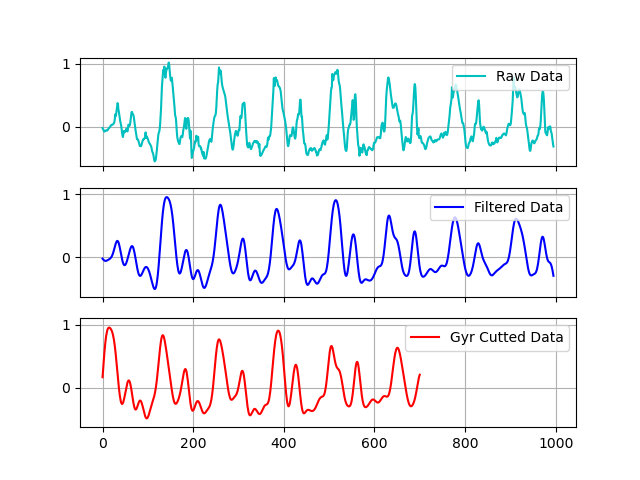

In [82]:
# pos = 'Normal', 'Upstairs', 'Downstairs'
pos = 'Normal'
# loc = 1, 3
loc = 3
# no = 0-7
no = 5
# axis = 0, 1, 2
axis = 0

plt.close()
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)

axs[0].plot(eval(f'gyr{pos}_s{loc}')[no].iloc[:,(axis+1)], label='Raw Data', c = 'c')
axs[1].plot(eval(f'gyrFiltered{pos}_s{loc}')[no][:,axis], label='Filtered Data', c = 'b')
axs[2].plot(eval(f'gyrCut{pos}_s{loc}')[no][:,axis], label = 'Gyr Cutted Data', c = 'r')
# plt.plot(eval(f'gyrResample{pos}_s{loc}')[no][:,axis], label = 'Gyr Resampled Data', c = 'g')

axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.show()

#### -- Test -- Save all cut data to plots

In [83]:
'''
for j in gaitpos:
    for i in smartphone:
        # variables of raw the data
        gyrl = eval(f'gyr{j}_s{i}')
        accl = eval(f'acc{j}_s{i}')
        # variables of filtered the data
        gyrF = eval(f'gyrFiltered{j}_s{i}')
        accF = eval(f'accFiltered{j}_s{i}')
        # variables of cutted the data
        gyrC = eval(f'gyrCut{j}_s{i}')
        accC = eval(f'accCut{j}_s{i}')

        for rg in range(0, len(gyrF)):
            plt.close()
            plt.plot(gyrl[rg].iloc[:,1], label='Raw Gyroscope Data', c = 'c')
            # plt.plot(accl[rg].iloc[:,1], label='Raw Accelerometer Data', c = 'm')

            plt.plot(gyrF[rg][:,0], label='Filtered Gyroscope Data', c = 'b')
            # plt.plot(accF[rg][:,0], label='Filtered Accelerometer Data', c = 'g')

            plt.plot(gyrC[rg][:,0], label='Gyroscope Cut Data', c = 'y')
            # plt.plot(accC[rg][:,0], label = 'Accelerometer Cut Data', c = 'r')

            plt.legend()
            plt.grid()
            plt.ioff()
            # plt.savefig(rootdir+f'/2 Accelerometer_Pictures/acc{j}_s{i}_{rg}.png')
            plt.savefig(rootdir+f'/1 Gyroscope_Pictures/gyr{j}_s{i}_{rg}.png')
'''

"\nfor j in gaitpos:\n    for i in smartphone:\n        # variables of raw the data\n        gyrl = eval(f'gyr{j}_s{i}')\n        accl = eval(f'acc{j}_s{i}')\n        # variables of filtered the data\n        gyrF = eval(f'gyrFiltered{j}_s{i}')\n        accF = eval(f'accFiltered{j}_s{i}')\n        # variables of cutted the data\n        gyrC = eval(f'gyrCut{j}_s{i}')\n        accC = eval(f'accCut{j}_s{i}')\n\n        for rg in range(0, len(gyrF)):\n            plt.close()\n            plt.plot(gyrl[rg].iloc[:,1], label='Raw Gyroscope Data', c = 'c')\n            # plt.plot(accl[rg].iloc[:,1], label='Raw Accelerometer Data', c = 'm')\n\n            plt.plot(gyrF[rg][:,0], label='Filtered Gyroscope Data', c = 'b')\n            # plt.plot(accF[rg][:,0], label='Filtered Accelerometer Data', c = 'g')\n\n            plt.plot(gyrC[rg][:,0], label='Gyroscope Cut Data', c = 'y')\n            # plt.plot(accC[rg][:,0], label = 'Accelerometer Cut Data', c = 'r')\n\n            plt.legend()\n      

### Cut data of each single motion

#### 2nd Cut data function

In [84]:
def cut2Data(gyrCut, accCut, freq):
    # axis to consider for the cut data again (0, 1, 2)
    axis = 1

    peaks, _ = sp.find_peaks(gyrCut[:,axis], height = 0, distance=freq*0.5)
    
    gyr_2cut = []
    acc_2cut = []
    
    for i in range(0, len(peaks)-1):
           
        gyr = gyrCut[peaks[i]:peaks[i+1], :]
        acc = accCut[peaks[i]:peaks[i+1], :]

        gyr_2cut.append(gyr)
        acc_2cut.append(acc)

    return gyr_2cut, acc_2cut

#### -- Check -- cut data algorithm

In [85]:
'''
axis = 1
tCut = np.asarray(gyrNormal_s3[0].iloc[:,0])
freq = np.round(len(tCut)/(tCut[-1]))
gyr2cut = []
acc2cut = []

peaks, _ = sp.find_peaks(gyrCutNormal_s3[0][:,axis], height = -10, distance=freq*0.5)
for i in range(0, len(peaks)-1):

    gyr = gyrCutNormal_s3[0][peaks[i]:peaks[i+1], :]
    acc = accCutNormal_s3[0][peaks[i]:peaks[i+1], :]

    gyr2cut.append(gyr)
    acc2cut.append(acc)
'''

'\naxis = 1\ntCut = np.asarray(gyrNormal_s3[0].iloc[:,0])\nfreq = np.round(len(tCut)/(tCut[-1]))\ngyr2cut = []\nacc2cut = []\n\npeaks, _ = sp.find_peaks(gyrCutNormal_s3[0][:,axis], height = -10, distance=freq*0.5)\nfor i in range(0, len(peaks)-1):\n\n    gyr = gyrCutNormal_s3[0][peaks[i]:peaks[i+1], :]\n    acc = accCutNormal_s3[0][peaks[i]:peaks[i+1], :]\n\n    gyr2cut.append(gyr)\n    acc2cut.append(acc)\n'

In [86]:
'''
plt.close()
fig, axs = plt.subplots(2, 1, sharex=True)

axs[0].plot(gyrCutNormal_s3[0][:,1], label = 'Cut Gyroscope Data', c = 'c')
axs[0].plot(peaks, gyrCutNormal_s3[0][:,1][peaks], 'x', label = 'Peaks', c = 'r')
axs[1].plot(gyr2cut[0][:,1], label = '2nd Cut Gyroscope Data', c = 'b')

plt.legend()
plt.show()
'''

"\nplt.close()\nfig, axs = plt.subplots(2, 1, sharex=True)\n\naxs[0].plot(gyrCutNormal_s3[0][:,1], label = 'Cut Gyroscope Data', c = 'c')\naxs[0].plot(peaks, gyrCutNormal_s3[0][:,1][peaks], 'x', label = 'Peaks', c = 'r')\naxs[1].plot(gyr2cut[0][:,1], label = '2nd Cut Gyroscope Data', c = 'b')\n\nplt.legend()\nplt.show()\n"

#### 2nd Cut all the data

In [87]:
# Create arrays for 2nd Cut data
for x in gaitpos:
    for y in smartphone:
        # variables of raw the data
        globals()['gyr2Cut%s_s%s' % (x, y)] = []
        globals()['acc2Cut%s_s%s' % (x, y)] = []
##---------------------------------------------------------------------------------------------------------------------

for j in gaitpos:
    for i in smartphone:
        # variables of raw the data
        gyrl = eval(f'gyr{j}_s{i}')
        accl = eval(f'acc{j}_s{i}')
        
        gyrc = eval(f'gyrCut{j}_s{i}')
        accc = eval(f'accCut{j}_s{i}')
        
        gyr2c = eval(f'gyr2Cut{j}_s{i}')
        acc2c = eval(f'acc2Cut{j}_s{i}')

        # Filter all the data
        for r in range(0, len(gyrc)):
            
            tCut = np.asarray(gyrl[r].iloc[:,0])
            freqCut = np.round(len(tCut)/(tCut[-1]))
            
            gf, aF = cut2Data(gyrc[r], accc[r], freqCut)

            gyr2c.append(gf)
            acc2c.append(aF)

#### Plot to check the 2nd cut data

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
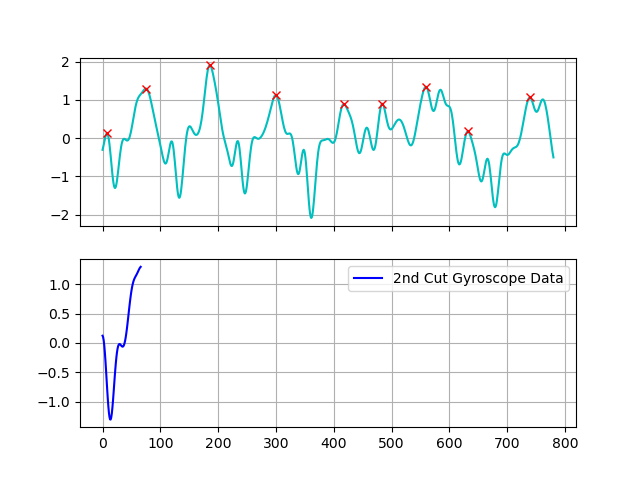

In [88]:
# print(peaks)
tCut = np.asarray(gyrNormal_s3[1].iloc[:,0])
freqCut = np.round(len(tCut)/(tCut[-1]))
peaks, _ = sp.find_peaks(gyrCutNormal_s3[1][:,1], height = 0, distance=freqCut*0.6)

plt.close()
fig, axs = plt.subplots(2, 1, sharex = True)

axs[0].plot(gyrCutNormal_s3[1][:,1], label = 'Cut Gyroscope Data', c = 'c')
axs[0].plot(peaks, gyrCutNormal_s3[1][:,1][peaks], 'x', label = 'Peaks', c = 'r')
axs[1].plot(gyr2CutNormal_s3[1][0][:,1], label = '2nd Cut Gyroscope Data', c = 'b')

# axs[0].legend()
axs[1].legend()
plt.show()

### Resample data

#### Resample all the data

In [89]:
# Create arrays for resampled data
for x in gaitpos:
    for y in smartphone:
        # variables of raw the data
        globals()['gyrResample%s_s%s' % (x, y)] = []
        globals()['accResample%s_s%s' % (x, y)] = []
##---------------------------------------------------------------------------------------------------------------------

size = 50

for j in gaitpos:
    for i in smartphone:
            gyrl = eval(f'gyr2Cut{j}_s{i}')
            accl = eval(f'acc2Cut{j}_s{i}')

            gyrrs = eval(f'gyrResample{j}_s{i}')
            accrs = eval(f'accResample{j}_s{i}')

            for rg in range(0, len(gyrl)):
                gr = []; ar = []
                for rp in range(0, len(gyrl[rg])):

                    g = sp.resample(gyrl[rg][rp], size, axis = 0)
                    a = sp.resample(accl[rg][rp], size, axis = 0)
                    
                    gr.append(g)
                    ar.append(a)

                gyrrs.append(gr)
                accrs.append(ar)

#### -- Sample Code -- Test code for resampling

In [90]:
'''
q = []
for j in range(0, len(gyr2CutNormal_s3)):
    p = []
    for i in range(0, len(gyr2CutNormal_s3[j])):
        x = sp.resample(gyr2CutNormal_s3[j][i], 50, axis = 0)
        p.append(x)
    q.append(p)
'''

'\nq = []\nfor j in range(0, len(gyr2CutNormal_s3)):\n    p = []\n    for i in range(0, len(gyr2CutNormal_s3[j])):\n        x = sp.resample(gyr2CutNormal_s3[j][i], 50, axis = 0)\n        p.append(x)\n    q.append(p)\n'

#### Check if all the data is collected properly after resampling

In [91]:
# getting the data shape for reference
for j in gaitpos:
    for i in smartphone:
            gyr = eval(f'gyrResample{j}_s{i}')
            acc = eval(f'accResample{j}_s{i}')

            print(f'Shape of gyrResample{j}_s{i} is ------ {np.asarray((gyr), dtype = list).shape}')
            print(f'Shape of accResample{j}_s{i} is ------ {np.asarray((acc), dtype = list).shape} \n')

Shape of gyrResampleNormal_s3 is ------ (8,)
Shape of accResampleNormal_s3 is ------ (8,) 

Shape of gyrResampleUpstairs_s3 is ------ (8,)
Shape of accResampleUpstairs_s3 is ------ (8,) 

Shape of gyrResampleDownstairs_s3 is ------ (8,)
Shape of accResampleDownstairs_s3 is ------ (8,) 



#### Plot to compare the cut data, and resampled data

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
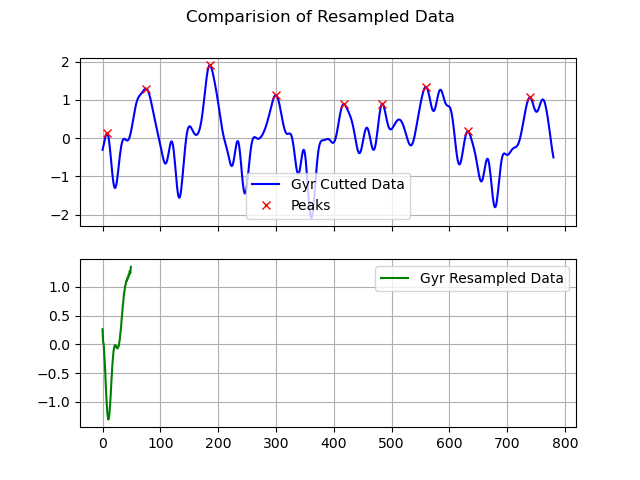

In [92]:
pos = 'Normal'  # pos = 'Normal', 'Upstairs', 'Downstairs'
loc = 3         # loc = 1, 3
no = 1          # no = 0-7
axis = 1        # axis = 0, 1, 2

# print(peaks)
tCut = np.asarray(eval(f'gyr{pos}_s{loc}')[no].iloc[:,0])
freqCut = np.round(len(tCut)/(tCut[-1]))
peaks, _ = sp.find_peaks(eval(f'gyrCut{pos}_s{loc}')[no][:,axis], height = 0, distance=freqCut*0.5)

plt.close()
fig, axs = plt.subplots(2,1, sharex=True)
fig.suptitle('Comparision of Resampled Data')

axs[0].plot(eval(f'gyrCut{pos}_s{loc}')[no][:,axis], label = 'Gyr Cutted Data', c = 'b')
axs[0].plot(peaks, eval(f'gyrCut{pos}_s{loc}')[no][:,axis][peaks], 'x', label = 'Peaks', c = 'r')
axs[1].plot(eval(f'gyrResample{pos}_s{loc}')[no][0][:,axis], label = 'Gyr Resampled Data', c = 'g')

axs[0].legend()
axs[1].legend()
plt.show()

### Combine data of all subjects

#### Create Variables for the combined data

In [93]:
# Create arrays for resampled data
for x in gaitpos:
    for y in smartphone:
        # variables of raw the data
        globals()['%s_s%s' % (x, y)] = []
##---------------------------------------------------------------------------------------------------------------------

#### Combining gyr and acc data

In [94]:
for j in gaitpos:
    for i in smartphone:
        gyr = eval(f'gyrResample{j}_s{i}')
        acc = eval(f'accResample{j}_s{i}')

        r = eval(f'{j}_s{i}')

        for y in range(0, len(gyr)):    
            o = []
            for x in range(0, len(gyr[y])):
                v = np.concatenate((gyr[y][x],acc[y][x]), axis = 1)
                o.append(v)
            r.append(o)

### PCA

#### run PCA on all the data

In [95]:
## Run PCA on the data
for j in gaitpos:
    for i in smartphone:
        phone = eval(f'{j}_s{i}')
        
        for x in range(0, len(phone)):
            for y in range(0, len(phone[x])):
                p = pd.DataFrame(phone[x][y])
                scale = StandardScaler().fit_transform(p)

                pca = PCA(n_components = 6)
                pca.fit(scale)
                phone[x][y] = pca.transform(scale)

#### pcaDffor scatter plot

In [96]:
var = np.round(pca.explained_variance_ratio_, decimals=3)*100
labels = [f'PC{x}' for x in range(1, len(var)+1)]


pcaDf = pd.DataFrame(columns = labels)
for j in gaitpos:
    for i in smartphone:
        phone = eval(f'{j}_s{i}')
        for x in range(0, len(phone)):
            xqc = pd.DataFrame(columns=labels)
            for y in range(0, len(phone[x])):
                pc = pd.DataFrame(phone[x][y], columns = labels)
                xqc = pd.concat([xqc, pc], ignore_index = True, axis = 0)
            pcaDf = pd.concat([pcaDf,xqc], ignore_index=True, axis = 0)

#### Check the scree plot

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
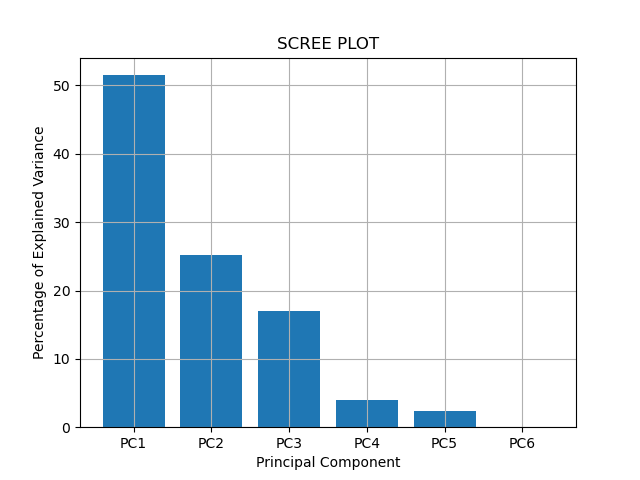

In [97]:
plt.close()
plt.bar(x = range(1, len(var)+1), height = var, tick_label = labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('SCREE PLOT')
plt.show()

#### -- Check -- which axis data is clustering from the scatter plot

In [98]:
'''
loadingScores = pd.Series(phone[0][0][:,0], index = np.linspace(0,49,50))
sortedLoadingScores = loadingScores.abs().sort_values(ascending=False)

topData = sortedLoadingScores[0:10].index.values

print('Top two principal components are -')
print(loadingScores[topData])
'''

"\nloadingScores = pd.Series(phone[0][0][:,0], index = np.linspace(0,49,50))\nsortedLoadingScores = loadingScores.abs().sort_values(ascending=False)\n\ntopData = sortedLoadingScores[0:10].index.values\n\nprint('Top two principal components are -')\nprint(loadingScores[topData])\n"

#### Scatter plot

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
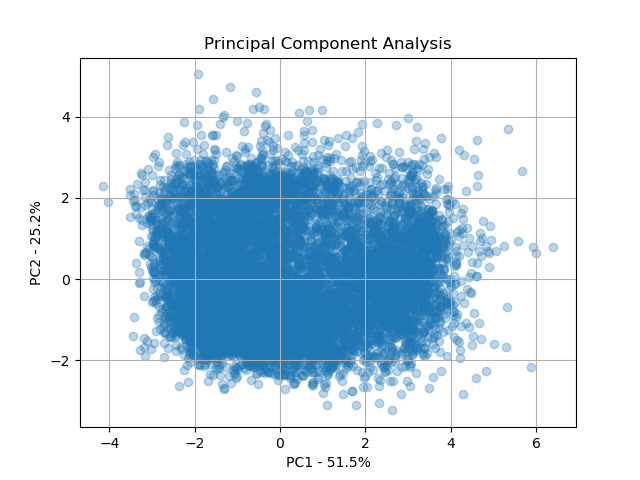

In [99]:
plt.close()
plt.scatter(pcaDf.PC1, pcaDf.PC2, cmap = 'viridis', alpha = 0.3)

plt.title('Principal Component Analysis')
plt.xlabel(f'PC1 - {var[0]}%')
plt.ylabel(f'PC2 - {var[1]}%')
plt.show()

# for name in pcaDf.index:
#     plt.annotate(name, (pcaDf.PC1[name], pcaDf.PC2[name]))

#### Normalize the data

In [100]:
# Create arrays for normalized data
for x in gaitpos:
    for y in smartphone:
        # variables of raw the data
        globals()['%s_s%s_n' % (x, y)] = [] # Normal_s1_n, Normal_s3_n, Upstairs_s1_n, Upstairs_s3_n, Downstairs_s1_n, Downstairs_s3_n
##---------------------------------------------------------------------------------------------------------------------

for j in gaitpos:
    for i in smartphone:
        ss = eval(f'{j}_s{i}')
        ss_n = eval(f'{j}_s{i}_n')
        for y in range(0, len(ss)):
            o = []
            for x in range(0, len(ss[y])):
                v = ss[y][x]
                v_n = preprocessing.normalize(v, norm = 'l2', axis = 1)
                o.append(v_n)
            ss_n.append(o)

#### Combine and Label the normalized data

In [101]:
x = []
y = []
for k in gaitpos:
    for l in smartphone:

        if k == 'Normal':    
            for i in range(0, len(Normal_s3_n)):
                for j in range(0, len(Normal_s3_n[i])):
                    x.append(Normal_s3_n[i][j])
                    y.append(k)
        elif k == 'Upstairs':
            for i in range(0, len(Upstairs_s3_n)):
                for j in range(0, len(Upstairs_s3_n[i])):
                    x.append(Upstairs_s3_n[i][j])
                    y.append(k)
        elif k == 'Downstairs':
            for i in range(0, len(Downstairs_s3_n)):
                for j in range(0, len(Downstairs_s3_n[i])):
                    x.append(Downstairs_s3_n[i][j])
                    y.append(k)

In [118]:
print(f'Length of data is {len(x)} \nLength of labels is {len(y)}')
y1=pd.DataFrame(y,columns=['Label'])
y1

Length of data is 221 
Length of labels is 221


,Label
0,Normal
1,Normal
2,Normal
3,Normal
4,Normal
...,...
216,Downstairs
217,Downstairs
218,Downstairs
219,Downstairs


In [115]:
from sklearn.preprocessing import LabelEncoder
# MultiColumnLabelEncoder(columns = ['Labela']).fit_transform(s3)
label = LabelEncoder()
y1['Label'] = label.fit_transform(y1['Label'])
y1.values.tolist()

[[1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [2],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
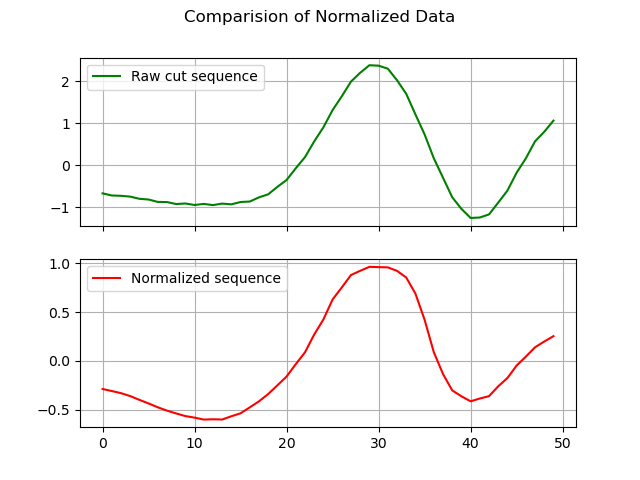

In [119]:
plt.close()
fig, axs = plt.subplots(2,1, sharex = True)
fig.suptitle('Comparision of Normalized Data')
axs[1].plot(Normal_s3_n[0][1][:,1], label = 'Normalized sequence', c = 'r')
axs[0].plot(Normal_s3[0][1][:,1], label = 'Raw cut sequence', c = 'g')

axs[0].legend()
axs[1].legend()
plt.show()

#### Output from PCA (normalize before input to AI)

In [ ]:
'''
x = []; y = []

for i in range(0, len(p)):
    if i % 2 == 0:
        x.append(p[i])
    elif i % 2 != 0:
        y.append(p[i])
'''

## ---> AI Model

In [149]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


x_train, x_test, y_train, y_test = train_test_split(x, y ,test_size = 0.25, shuffle=False)


(42,)

In [183]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model=Sequential()


kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
cvscores = []
for train, test in kfold.split(x, y):
    
    model.add(Dense(300, input_dim=6, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=150, batch_size=10, verbose=0)
    scores = model.evaluate(x_test, y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

X=[train]
Y=[test]

accuracy: 40.48%
40.48% (+/- 0.00%)
accuracy: 42.86%
41.67% (+/- 1.19%)
accuracy: 45.24%
42.86% (+/- 1.94%)
accuracy: 66.67%
48.81% (+/- 10.45%)
accuracy: 47.62%
48.57% (+/- 9.36%)
accuracy: 47.62%
48.41% (+/- 8.55%)
accuracy: 50.00%
48.64% (+/- 7.93%)
accuracy: 50.00%
48.81% (+/- 7.43%)


In [181]:
predictions = model.predict(X)
rounded = [round(x1[0]) for x1 in predictions]
print(rounded)
results = confusion_matrix(Y, rounded)
print(results)

ValueError: in user code:

    C:\Users\Shiva\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\Shiva\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Shiva\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Shiva\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Shiva\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Shiva\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\Shiva\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\Shiva\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\Shiva\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential_21 is incompatible with the layer: expected axis -1 of input shape to have value 6 but received input with shape [None, 1]


In [168]:
test

array([ 13,  15,  17,  20,  23,  32,  33,  35,  47,  49,  53,  59,  64,
        68,  75,  86,  94,  95, 101, 104, 105, 114, 118, 120, 130, 131,
       134, 135, 138, 146, 153, 154, 159])

In [167]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cvscores = []
for train, test in kfold.split(x, y):
    model.add(Dense(12, input_dim=6, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=150, batch_size=10, verbose=0)
    scores = model.evaluate(x_test, y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

accuracy: 33.33%
33.33% (+/- 0.00%)
accuracy: 33.33%
33.33% (+/- 0.00%)
accuracy: 33.33%
33.33% (+/- 0.00%)
accuracy: 33.33%
33.33% (+/- 0.00%)
accuracy: 33.33%
33.33% (+/- 0.00%)


In [148]:
# evaluate a logistic regression model using k-fold cross-validation
# from numpy import mean
# from numpy import std
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
# from sklearn.linear_model import LogisticRegression
# x, y = make_classification(n_samples=165, n_features=6, n_informative=5, n_redundant=1, random_state=1)
# # prepare the cross-validation procedure
# cv = KFold(n_splits=10, random_state=1, shuffle=True)
# cv1= KFold(n_splits=5, random_state=1, shuffle=True)
# cv2= KFold(n_splits=2, random_state=1, shuffle=True)
# # create model
# model = LogisticRegression()
# # evaluate model
# scores = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# scores1 = cross_val_score(model, x_test, y_test, scoring='accuracy', cv=cv1, n_jobs=-1)
# scores2 = cross_val_score(model, x, y, scoring='accuracy', cv=cv2, n_jobs=-1)
# # report performance
# print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
# print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores1)))
# print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores2)))


Accuracy: 0.726 (0.108)
Accuracy: 0.726 (0.131)
Accuracy: 0.726 (0.050)


In [161]:
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers  import SGD
from tensorflow.keras.models import Sequential

model3=Sequential()
sgd= SGD(lr=0.01, decay=1e-6, momentum=0.9)

model3.compile(loss=mean_squared_error,optimizer=sgd)
model3.fit(x_train,y_train,batch_size=15,epochs=100)

model3.evaluate(x_test,y_test, batch_size=15)




Epoch 1/100
9/9 [==============================] - 0s 556us/step - loss: 3.5442
Epoch 2/100
9/9 [==============================] - 0s 445us/step - loss: 3.5442
Epoch 3/100
9/9 [==============================] - 0s 445us/step - loss: 3.5442
Epoch 4/100
9/9 [==============================] - 0s 445us/step - loss: 3.5442
Epoch 5/100
9/9 [==============================] - 0s 334us/step - loss: 3.5442
Epoch 6/100
9/9 [==============================] - 0s 445us/step - loss: 3.5442
Epoch 7/100
9/9 [==============================] - 0s 333us/step - loss: 3.5442
Epoch 8/100
9/9 [==============================] - 0s 445us/step - loss: 3.5442
Epoch 9/100
9/9 [==============================] - 0s 445us/step - loss: 3.5442
Epoch 10/100
9/9 [==============================] - 0s 556us/step - loss: 3.5442
Epoch 11/100
9/9 [==============================] - 0s 556us/step - loss: 3.5442
Epoch 12/100
9/9 [==============================] - 0s 512us/step - loss: 3.5442
Epoch 13/100
9/9 [===================

3.009756088256836